# Feature Extraction and Imputation Analysis

This notebook queries the cleaned feature views created in the database and analyzes the complete feature set for our prolonged ICU stay prediction model.

**Key Focus Areas:**
- Query `v_features_icu_stay_clean` (cleaned version with numeric age and unknown gender handling)
- Analyze missing values across all feature groups
- Examine data distributions
- Prepare for imputation strategy

**Feature Groups Available:**
- Target variable (prolonged_stay)
- Patient demographics (cleaned - age_numeric and gender)
- APACHE APS (Acute Physiology Score)
- GCS Missingness Indicators (is_missing_gcs_*)
- APACHE predictors
- Vitals (first 24h)
- Labs (first 24h)
- Respiratory features (first 24h)
- Infusion features (first 24h)

## Setup

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set plot style
plt.style.use('default')
sns.set_palette('husl')

In [2]:
# Connect to database
db_path = Path("../../data/duckdb/fedlearn.duckdb")
conn = duckdb.connect(str(db_path), read_only=True)

print(f"Connected to database: {db_path}")
print(f"Database exists: {db_path.exists()}")

Connected to database: ../../data/duckdb/fedlearn.duckdb
Database exists: True


## Verify Available Views

Let's confirm all feature views are available in the database.

In [3]:
# List all views in the database
views_query = """
SELECT table_name 
FROM information_schema.tables 
WHERE table_type = 'VIEW' 
  AND table_name LIKE 'v_features%'
ORDER BY table_name
"""

views_df = conn.execute(views_query).fetchdf()
print(f"\nFound {len(views_df)} feature views:")
print(views_df.to_string(index=False))


Found 10 feature views:
               table_name
    v_features_apache_aps
   v_features_apache_pred
      v_features_icu_stay
v_features_icu_stay_clean
 v_features_infusions_24h
      v_features_labs_24h
       v_features_patient
      v_features_resp_24h
        v_features_target
    v_features_vitals_24h


## Query Complete Feature Set

Query all features from the cleaned ICU stay view. This view includes:
- **age_numeric**: Converted from string to numeric (>89 → 90)
- **gender**: Set to "unknown" when blank
- **GCS missingness indicators**: Three new binary features (is_missing_gcs_eyes, is_missing_gcs_verbal, is_missing_gcs_motor)
- All other feature groups joined together

In [4]:
# Query the complete cleaned feature set
features_query = """
SELECT *
FROM v_features_icu_stay_clean
"""

df_features = conn.execute(features_query).fetchdf()

print(f"Dataset shape: {df_features.shape}")
print(f"Number of ICU stays: {df_features['patientunitstayid'].nunique():,}")
print(f"Number of features: {len(df_features.columns) - 1}")

Dataset shape: (199646, 77)
Number of ICU stays: 199,646
Number of features: 76


In [5]:
# Display first few rows
df_features.head()

,patientunitstayid,los_days,prolonged_stay,age_numeric,gender,ethnicity,admissionheight,admissionweight,unittype,unitadmitsource,unitvisitnumber,hospitaladmitsource,apacheadmissiondx,admissiondx_category,numbedscategory,teachingstatus,hospital_region,apache_intubated,apache_vent,apache_dialysis,apache_urine_24h,apache_wbc,apache_temp,apache_rr,apache_sodium,apache_hr,apache_meanbp,apache_ph,apache_hct,apache_creatinine,apache_albumin,apache_pao2,apache_pco2,apache_bun,apache_glucose,apache_bilirubin,apache_gcs_eyes,apache_gcs_verbal,apache_gcs_motor,apache_fio2,is_missing_gcs_eyes,is_missing_gcs_verbal,is_missing_gcs_motor,apache_bedcount,apache_admitsource_code,apache_diabetes,apache_aids,apache_hepaticfailure,apache_lymphoma,apache_metastaticcancer,apache_leukemia,apache_immunosuppression,apache_cirrhosis,apache_electivesurgery,apache_readmit,apache_ventday1,apache_oobventday1,apache_oobintubday1,avg_hr_24h,min_hr_24h,max_hr_24h,avg_rr_24h,min_rr_24h,max_rr_24h,avg_sao2_24h,min_sao2_24h,max_sao2_24h,creatinine_mean_24h,creatinine_max_24h,wbc_mean_24h,glucose_mean_24h,vent_started_24h,ever_vented,pressor_norepi_24h,pressor_epi_24h,pressor_vaso_24h,sedative_propofol_24h
0,2683800,2.022222,0,64,female,Caucasian,162.6,56.5,Med-Surg ICU,Operating Room,1,Operating Room,Aortic valve replacement (isolated),other,250 - 499,False,None,0,1,0,-1.000,17.2,37.0,9.0,140.0,56.0,64.0,-1.000,31.7,0.38,-1.0,-1.0,-1.0,16.0,31.0,-1.0,4.0,5.0,6.0,-1.0,0,0,0,13,1,0,0,0,0,0,0,0,0,1,0,1,1,1,74.390845,56,85,16.306122,9,24,99.379928,96,100,0.506667,0.58,14.575,127.464286,1,1,0,0,0,0
1,2689908,4.368056,1,90,female,Caucasian,152.0,63.1,Med-Surg ICU,Operating Room,1,Operating Room,Aortic valve replacement (isolated),other,250 - 499,False,None,0,0,0,-1.000,7.4,35.6,28.0,138.0,97.0,50.0,-1.000,29.7,0.69,-1.0,-1.0,-1.0,20.0,204.0,-1.0,4.0,5.0,6.0,-1.0,0,0,0,13,1,0,0,0,0,0,0,0,0,1,0,0,1,1,81.574394,56,98,17.217993,10,28,97.478873,91,100,0.750000,0.80,8.975,144.954545,1,1,0,0,0,0
2,2704108,6.336111,1,52,male,Caucasian,182.9,98.0,Med-Surg ICU,Emergency Department,1,Emergency Department,"Sepsis, renal/UTI (including bladder)",sepsis,100 - 249,False,West,0,1,0,1323.648,17.1,33.9,29.0,149.0,117.0,57.0,-1.000,30.6,1.17,2.2,-1.0,-1.0,23.0,288.0,0.4,2.0,1.0,4.0,-1.0,0,0,0,58,8,1,0,0,0,0,0,0,0,<NA>,0,1,1,1,90.630662,64,117,18.407666,12,29,99.968641,99,100,1.030000,1.17,17.100,239.000000,1,1,1,1,0,0
3,2712055,4.956944,1,32,female,Hispanic,168.9,65.3,Med-Surg ICU,Floor,2,None,"Sepsis, other",sepsis,250 - 499,False,West,1,1,1,-1.000,18.2,36.7,29.0,134.0,111.0,155.0,7.499,25.4,6.57,2.4,421.0,35.4,83.0,163.0,0.7,1.0,1.0,1.0,100.0,0,0,0,84,4,0,0,0,0,0,0,0,0,<NA>,1,1,1,1,83.294964,71,105,15.967626,12,25,99.716912,96,100,5.180000,6.57,18.200,143.333333,1,1,0,0,0,0
4,2715224,1.734722,0,78,female,Caucasian,172.7,62.9,Med-Surg ICU,Operating Room,1,None,Spinal cord only trauma,trauma,100 - 249,False,West,0,1,0,-1.000,13.0,37.3,5.0,141.0,119.0,56.0,-1.000,34.5,1.31,2.1,-1.0,-1.0,29.0,233.0,0.4,4.0,4.0,5.0,-1.0,0,0,0,16,1,1,0,0,0,0,0,0,0,0,0,1,1,1,91.151852,67,119,15.662963,0,26,96.021368,87,100,1.203333,1.31,12.350,188.125000,1,1,0,0,0,1


In [6]:
# Display column names grouped by feature type
all_columns = df_features.columns.tolist()

print("\n=== Feature Column Groups ===")
print(f"\nID & Target (3 columns):")
print([c for c in all_columns if c in ['patientunitstayid', 'los_days', 'prolonged_stay']])

print(f"\nPatient Demographics (14 columns):")
print([c for c in all_columns if c in ['age_numeric', 'gender', 'ethnicity', 'admissionheight', 'admissionweight',
                                         'unittype', 'unitadmitsource', 'unitvisitnumber', 'hospitaladmitsource',
                                         'apacheadmissiondx', 'admissiondx_category', 'numbedscategory',
                                         'teachingstatus', 'hospital_region']])

print(f"\nAPACHE APS Features (23 columns):")
print([c for c in all_columns if c.startswith('apache_') and 'aps' in c.lower() or 
       c in ['apache_intubated', 'apache_vent', 'apache_dialysis', 'apache_urine_24h', 'apache_wbc',
             'apache_temp', 'apache_rr', 'apache_sodium', 'apache_hr', 'apache_meanbp', 'apache_ph',
             'apache_hct', 'apache_creatinine', 'apache_albumin', 'apache_pao2', 'apache_pco2',
             'apache_bun', 'apache_glucose', 'apache_bilirubin', 'apache_gcs_eyes', 'apache_gcs_verbal',
             'apache_gcs_motor', 'apache_fio2']])

print(f"\nGCS Missingness Indicators (3 columns):")
print([c for c in all_columns if c.startswith('is_missing_gcs')])

print(f"\nAPACHE Predictor Features (15 columns):")
print([c for c in all_columns if c.startswith('apache_') and c not in 
       ['apache_intubated', 'apache_vent', 'apache_dialysis', 'apache_urine_24h', 'apache_wbc',
        'apache_temp', 'apache_rr', 'apache_sodium', 'apache_hr', 'apache_meanbp', 'apache_ph',
        'apache_hct', 'apache_creatinine', 'apache_albumin', 'apache_pao2', 'apache_pco2',
        'apache_bun', 'apache_glucose', 'apache_bilirubin', 'apache_gcs_eyes', 'apache_gcs_verbal',
        'apache_gcs_motor', 'apache_fio2']])

print(f"\nVitals (24h) Features (9 columns):")
print([c for c in all_columns if '24h' in c and any(x in c for x in ['hr', 'rr', 'sao2'])])

print(f"\nLabs (24h) Features (4 columns):")
print([c for c in all_columns if '24h' in c and any(x in c for x in ['creatinine', 'wbc', 'glucose']) and 'apache' not in c])

print(f"\nRespiratory Features (2 columns):")
print([c for c in all_columns if c in ['vent_started_24h', 'ever_vented']])

print(f"\nInfusion Features (4 columns):")
print([c for c in all_columns if any(x in c for x in ['pressor', 'sedative'])])


=== Feature Column Groups ===

ID & Target (3 columns):
['patientunitstayid', 'los_days', 'prolonged_stay']

Patient Demographics (14 columns):
['age_numeric', 'gender', 'ethnicity', 'admissionheight', 'admissionweight', 'unittype', 'unitadmitsource', 'unitvisitnumber', 'hospitaladmitsource', 'apacheadmissiondx', 'admissiondx_category', 'numbedscategory', 'teachingstatus', 'hospital_region']

APACHE APS Features (23 columns):
['apache_intubated', 'apache_vent', 'apache_dialysis', 'apache_urine_24h', 'apache_wbc', 'apache_temp', 'apache_rr', 'apache_sodium', 'apache_hr', 'apache_meanbp', 'apache_ph', 'apache_hct', 'apache_creatinine', 'apache_albumin', 'apache_pao2', 'apache_pco2', 'apache_bun', 'apache_glucose', 'apache_bilirubin', 'apache_gcs_eyes', 'apache_gcs_verbal', 'apache_gcs_motor', 'apache_fio2']

GCS Missingness Indicators (3 columns):
['is_missing_gcs_eyes', 'is_missing_gcs_verbal', 'is_missing_gcs_motor']

APACHE Predictor Features (15 columns):
['apache_bedcount', 'apache

## Examine Cleaned Age and Gender

Let's verify the cleaning transformations:
- **age_numeric**: Converted from string to numeric (>89 → 90)
- **gender**: Set to "unknown" when blank
- **GCS missingness indicators**: Added is_missing_gcs_eyes, is_missing_gcs_verbal, is_missing_gcs_motor flags

In [7]:
# Age analysis
print("=== Age Distribution ===")
print(f"Data type: {df_features['age_numeric'].dtype}")
print(f"\nDescriptive statistics:")
print(df_features['age_numeric'].describe())
print(f"\nNull values: {df_features['age_numeric'].isnull().sum():,} ({df_features['age_numeric'].isnull().mean()*100:.2f}%)")
print(f"Value of 90 (converted from >89): {(df_features['age_numeric'] == 90).sum():,} patients")

=== Age Distribution ===
Data type: Int32

Descriptive statistics:
count     199554.0
mean     63.078615
std      17.182204
min            0.0
25%           53.0
50%           65.0
75%           76.0
max           90.0
Name: age_numeric, dtype: Float64

Null values: 92 (0.05%)
Value of 90 (converted from >89): 7,047 patients


In [8]:
# Gender analysis
print("=== Gender Distribution ===")
print(f"\nValue counts:")
print(df_features['gender'].value_counts())
print(f"\nNull values: {df_features['gender'].isnull().sum()}")
print(f"Unknown gender: {(df_features['gender'] == 'unknown').sum():,} patients")

=== Gender Distribution ===

Value counts:
gender
male       107715
female      91758
unknown       165
other           8
Name: count, dtype: int64

Null values: 0
Unknown gender: 165 patients


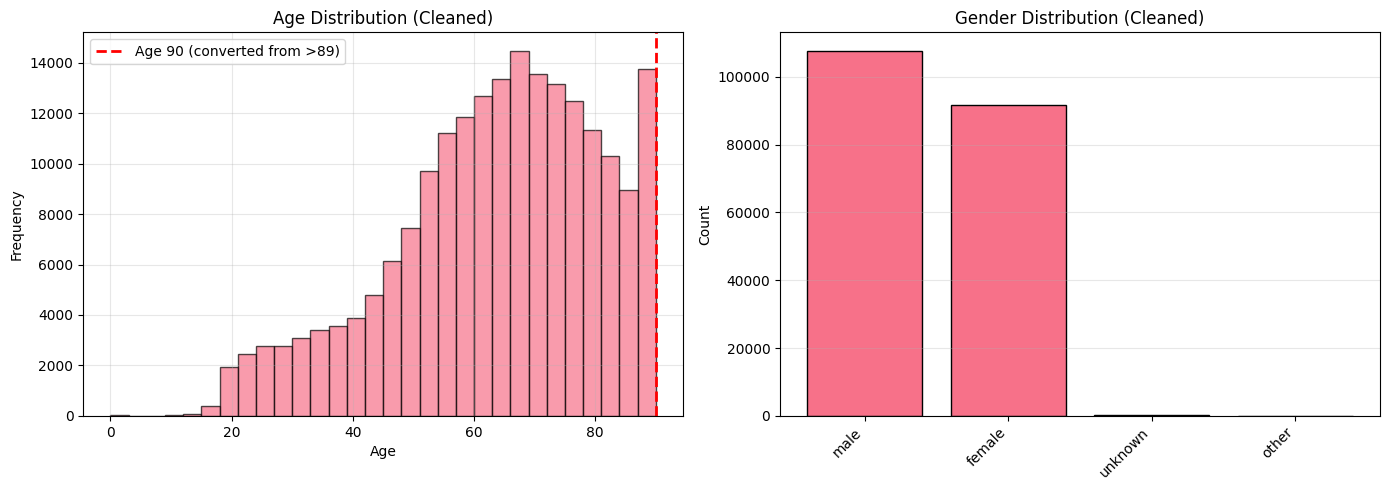

In [9]:
# Visualize age distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age histogram
axes[0].hist(df_features['age_numeric'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(90, color='red', linestyle='--', linewidth=2, label='Age 90 (converted from >89)')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution (Cleaned)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gender bar chart
gender_counts = df_features['gender'].value_counts()
axes[1].bar(range(len(gender_counts)), gender_counts.values, edgecolor='black')
axes[1].set_xticks(range(len(gender_counts)))
axes[1].set_xticklabels(gender_counts.index, rotation=45, ha='right')
axes[1].set_ylabel('Count')
axes[1].set_title('Gender Distribution (Cleaned)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Target Variable Analysis

=== Prolonged Stay Distribution ===

Value counts:
prolonged_stay
0    150206
1     49440
Name: count, dtype: int64

Percentages:
prolonged_stay
0    75.236168
1    24.763832
Name: proportion, dtype: float64


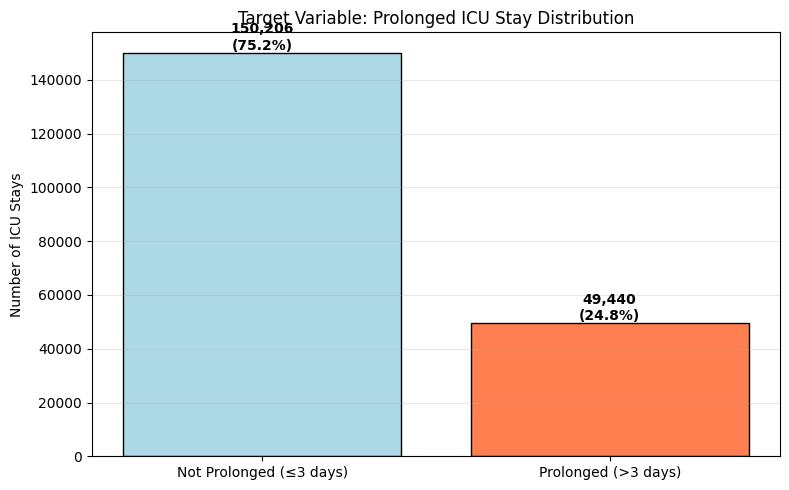

In [10]:
# Target variable distribution
print("=== Prolonged Stay Distribution ===")
print(f"\nValue counts:")
print(df_features['prolonged_stay'].value_counts())
print(f"\nPercentages:")
print(df_features['prolonged_stay'].value_counts(normalize=True) * 100)

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
target_counts = df_features['prolonged_stay'].value_counts()
colors = ['lightblue', 'coral']
ax.bar(['Not Prolonged (≤3 days)', 'Prolonged (>3 days)'], target_counts.values, color=colors, edgecolor='black')
ax.set_ylabel('Number of ICU Stays')
ax.set_title('Target Variable: Prolonged ICU Stay Distribution')
ax.grid(True, alpha=0.3, axis='y')

# Add percentage labels
for i, (count, pct) in enumerate(zip(target_counts.values, target_counts.values / target_counts.sum() * 100)):
    ax.text(i, count, f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Missing Value Analysis

Comprehensive analysis of missing values across all feature groups to inform imputation strategy.

In [11]:
# Calculate missing values for all features
missing_data = pd.DataFrame({
    'column': df_features.columns,
    'null_count': df_features.isnull().sum(),
    'null_percentage': (df_features.isnull().sum() / len(df_features) * 100).round(2),
    'non_null_count': df_features.notnull().sum(),
    'data_type': df_features.dtypes
}).reset_index(drop=True)

# Sort by null percentage descending
missing_data = missing_data.sort_values('null_percentage', ascending=False).reset_index(drop=True)

# Add severity category
missing_data['severity'] = pd.cut(
    missing_data['null_percentage'],
    bins=[-0.1, 10, 30, 50, 100],
    labels=['Low (<10%)', 'Medium (10-30%)', 'High (30-50%)', 'Critical (>50%)']
)

print("=== Missing Value Summary ===")
print(f"\nTotal features: {len(missing_data)}")
print(f"Features with missing values: {(missing_data['null_count'] > 0).sum()}")
print(f"Features fully populated: {(missing_data['null_count'] == 0).sum()}")
print(f"\nSeverity breakdown:")
print(missing_data['severity'].value_counts().sort_index())

=== Missing Value Summary ===

Total features: 77
Features with missing values: 66
Features fully populated: 11

Severity breakdown:
severity
Low (<10%)         23
Medium (10-30%)    47
High (30-50%)       0
Critical (>50%)     7
Name: count, dtype: int64


In [12]:
# Display features with missing values
print("\n=== Features with Missing Values ===")
missing_features = missing_data[missing_data['null_count'] > 0]
print(missing_features[['column', 'null_count', 'null_percentage', 'severity']].to_string(index=False))


=== Features with Missing Values ===
                  column  null_count  null_percentage        severity
  apache_electivesurgery      166425            83.36 Critical (>50%)
        vent_started_24h      154921            77.60 Critical (>50%)
             ever_vented      154921            77.60 Critical (>50%)
      pressor_norepi_24h      131917            66.08 Critical (>50%)
   sedative_propofol_24h      131917            66.08 Critical (>50%)
        pressor_vaso_24h      131917            66.08 Critical (>50%)
         pressor_epi_24h      131917            66.08 Critical (>50%)
     hospitaladmitsource       49118            24.60 Medium (10-30%)
            wbc_mean_24h       36895            18.48 Medium (10-30%)
     creatinine_mean_24h       30033            15.04 Medium (10-30%)
      creatinine_max_24h       30033            15.04 Medium (10-30%)
         apache_dialysis       29044            14.55 Medium (10-30%)
        apache_urine_24h       29044            14.5

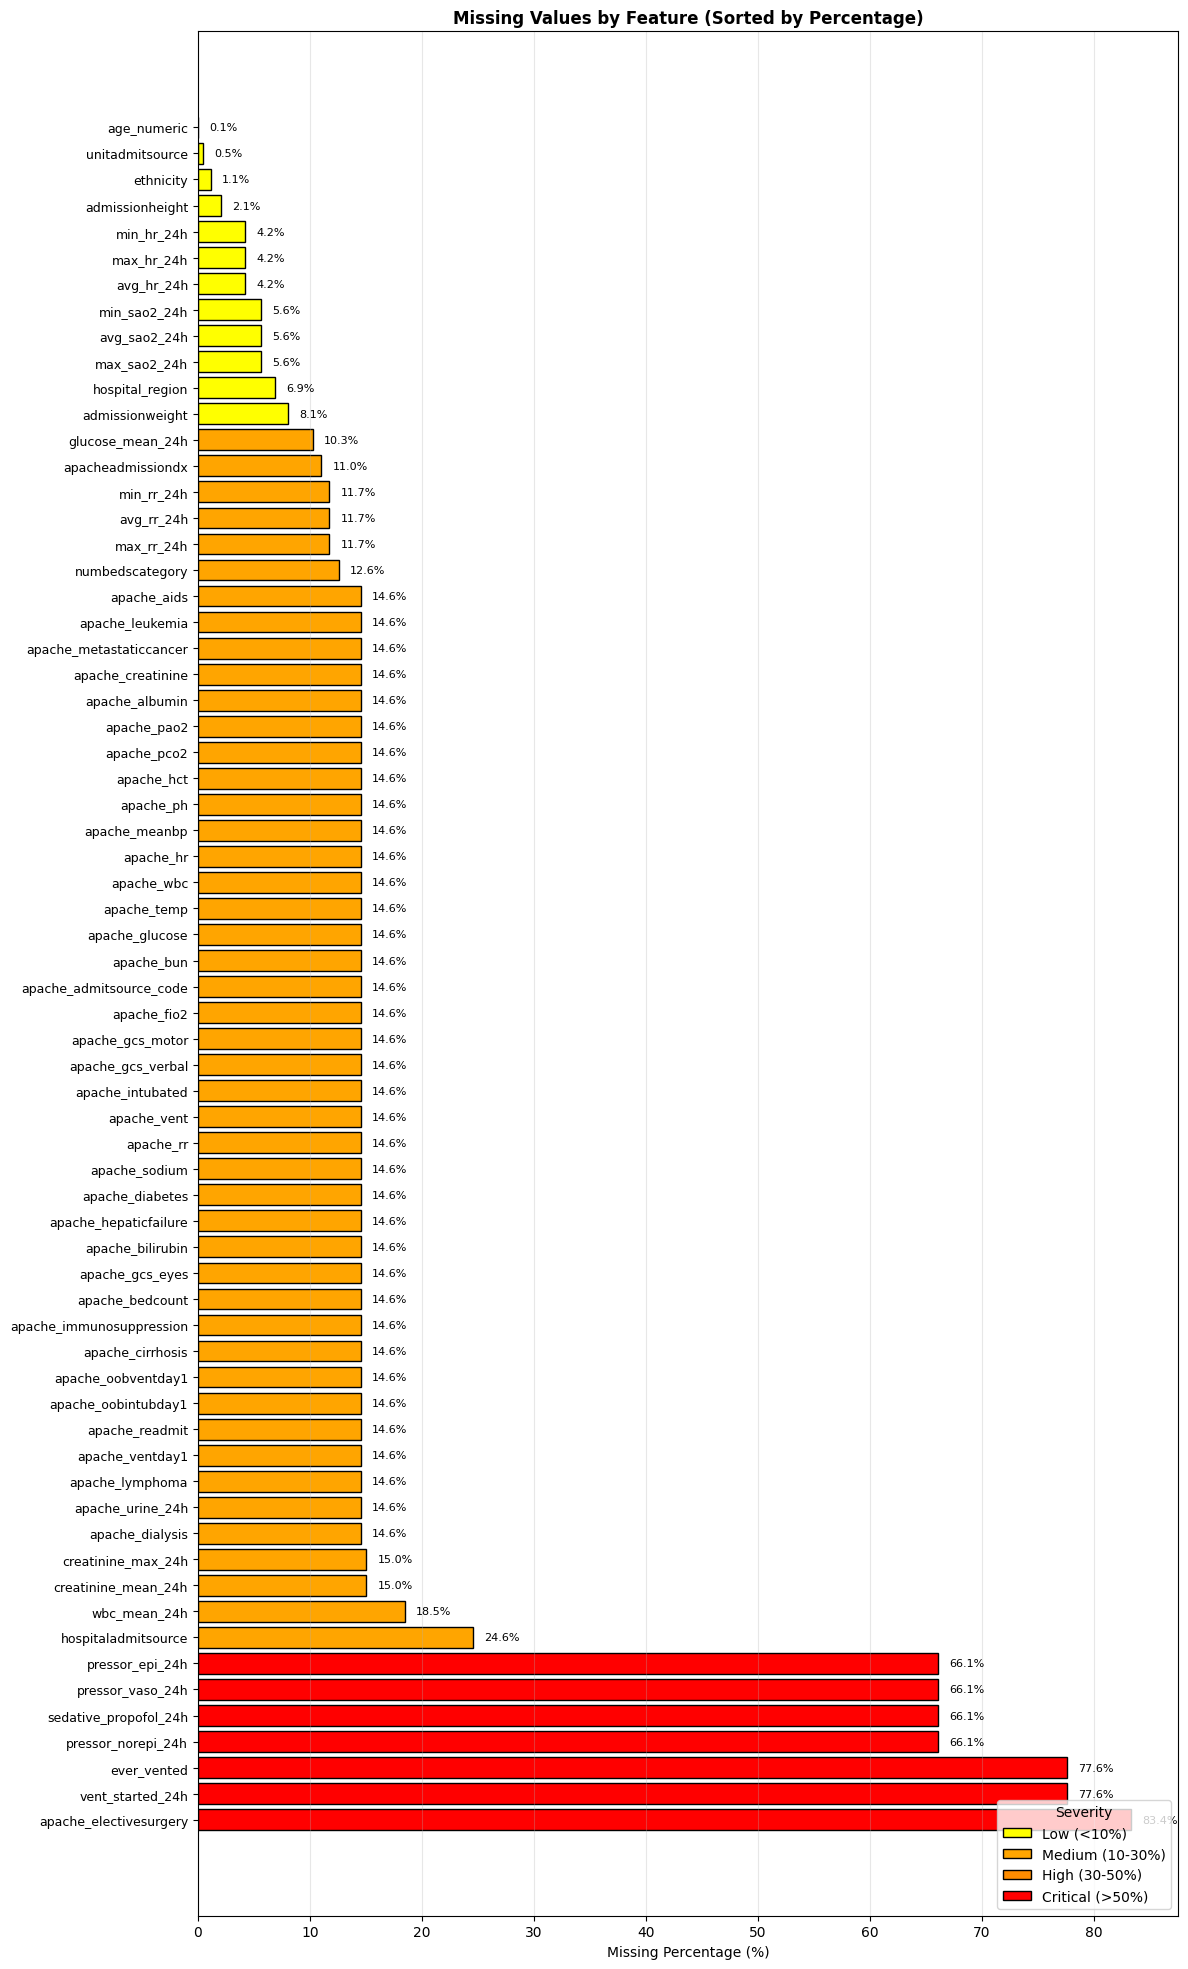

In [13]:
# Visualize missing values
missing_plot = missing_data[missing_data['null_count'] > 0].copy()

if len(missing_plot) > 0:
    # Create color mapping based on severity
    color_map = {
        'Low (<10%)': 'yellow',
        'Medium (10-30%)': 'orange',
        'High (30-50%)': 'darkorange',
        'Critical (>50%)': 'red'
    }
    colors = missing_plot['severity'].map(color_map)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, max(8, len(missing_plot) * 0.3)))
    y_pos = range(len(missing_plot))
    
    ax.barh(y_pos, missing_plot['null_percentage'], color=colors, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(missing_plot['column'], fontsize=9)
    ax.set_xlabel('Missing Percentage (%)')
    ax.set_title('Missing Values by Feature (Sorted by Percentage)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add percentage labels
    for i, (idx, row) in enumerate(missing_plot.iterrows()):
        ax.text(row['null_percentage'] + 1, i, f"{row['null_percentage']:.1f}%", 
                va='center', fontsize=8)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=severity) 
                      for severity, color in color_map.items()]
    ax.legend(handles=legend_elements, loc='lower right', title='Severity')
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset!")

## Missing Value Patterns by Feature Group

In [14]:
# Categorize features into groups
def categorize_feature(col_name):
    if col_name in ['patientunitstayid', 'los_days', 'prolonged_stay']:
        return 'ID & Target'
    elif col_name in ['age_numeric', 'gender', 'ethnicity', 'admissionheight', 'admissionweight',
                      'unittype', 'unitadmitsource', 'unitvisitnumber', 'hospitaladmitsource',
                      'apacheadmissiondx', 'admissiondx_category', 'numbedscategory',
                      'teachingstatus', 'hospital_region']:
        return 'Patient Demographics'
    elif col_name.startswith('is_missing_'):
        return 'Missingness Indicators'
    elif col_name.startswith('apache_') and col_name in ['apache_intubated', 'apache_vent', 'apache_dialysis', 
                                                           'apache_urine_24h', 'apache_wbc', 'apache_temp', 
                                                           'apache_rr', 'apache_sodium', 'apache_hr', 
                                                           'apache_meanbp', 'apache_ph', 'apache_hct', 
                                                           'apache_creatinine', 'apache_albumin', 'apache_pao2', 
                                                           'apache_pco2', 'apache_bun', 'apache_glucose', 
                                                           'apache_bilirubin', 'apache_gcs_eyes', 
                                                           'apache_gcs_verbal', 'apache_gcs_motor', 'apache_fio2']:
        return 'APACHE APS'
    elif col_name.startswith('apache_'):
        return 'APACHE Predictors'
    elif '24h' in col_name and any(x in col_name for x in ['hr', 'rr', 'sao2']):
        return 'Vitals (24h)'
    elif '24h' in col_name and any(x in col_name for x in ['creatinine', 'wbc', 'glucose']):
        return 'Labs (24h)'
    elif col_name in ['vent_started_24h', 'ever_vented']:
        return 'Respiratory'
    elif any(x in col_name for x in ['pressor', 'sedative']):
        return 'Infusions'
    else:
        return 'Other'

# Add feature group to missing data
missing_data['feature_group'] = missing_data['column'].apply(categorize_feature)

# Group by feature group
group_summary = missing_data.groupby('feature_group').agg({
    'column': 'count',
    'null_percentage': ['mean', 'min', 'max']
}).round(2)

group_summary.columns = ['Feature Count', 'Avg Missing %', 'Min Missing %', 'Max Missing %']
group_summary = group_summary.sort_values('Avg Missing %', ascending=False)

print("=== Missing Values by Feature Group ===")
print(group_summary)

=== Missing Values by Feature Group ===
                        Feature Count  Avg Missing %  Min Missing %  \
feature_group                                                         
Respiratory                         2          77.60          77.60   
Infusions                           4          66.08          66.08   
APACHE Predictors                  15          19.14          14.55   
Labs (24h)                          4          14.71          10.29   
APACHE APS                         23          14.55          14.55   
Vitals (24h)                        9           7.19           4.20   
Patient Demographics               14           4.78           0.00   
ID & Target                         3           0.00           0.00   
Missingness Indicators              3           0.00           0.00   

                        Max Missing %  
feature_group                          
Respiratory                     77.60  
Infusions                       66.08  
APACHE Predictors 

## Data Type Analysis

In [15]:
# Analyze data types
print("=== Data Type Distribution ===")
dtype_counts = df_features.dtypes.value_counts()
print(dtype_counts)

# Separate numeric and categorical features
numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_features.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

print(f"\nCategorical features:")
for feat in categorical_features:
    unique_count = df_features[feat].nunique()
    print(f"  - {feat}: {unique_count} unique values")

=== Data Type Distribution ===
float64    30
Int16      18
Int32      13
object      9
int32       6
bool        1
Name: count, dtype: int64

Numeric features: 67
Categorical features: 9

Categorical features:
  - gender: 4 unique values
  - ethnicity: 6 unique values
  - unittype: 8 unique values
  - unitadmitsource: 15 unique values
  - hospitaladmitsource: 15 unique values
  - apacheadmissiondx: 392 unique values
  - admissiondx_category: 7 unique values
  - numbedscategory: 4 unique values
  - hospital_region: 4 unique values


## Key Feature Distributions

Examine distributions of important numeric features.

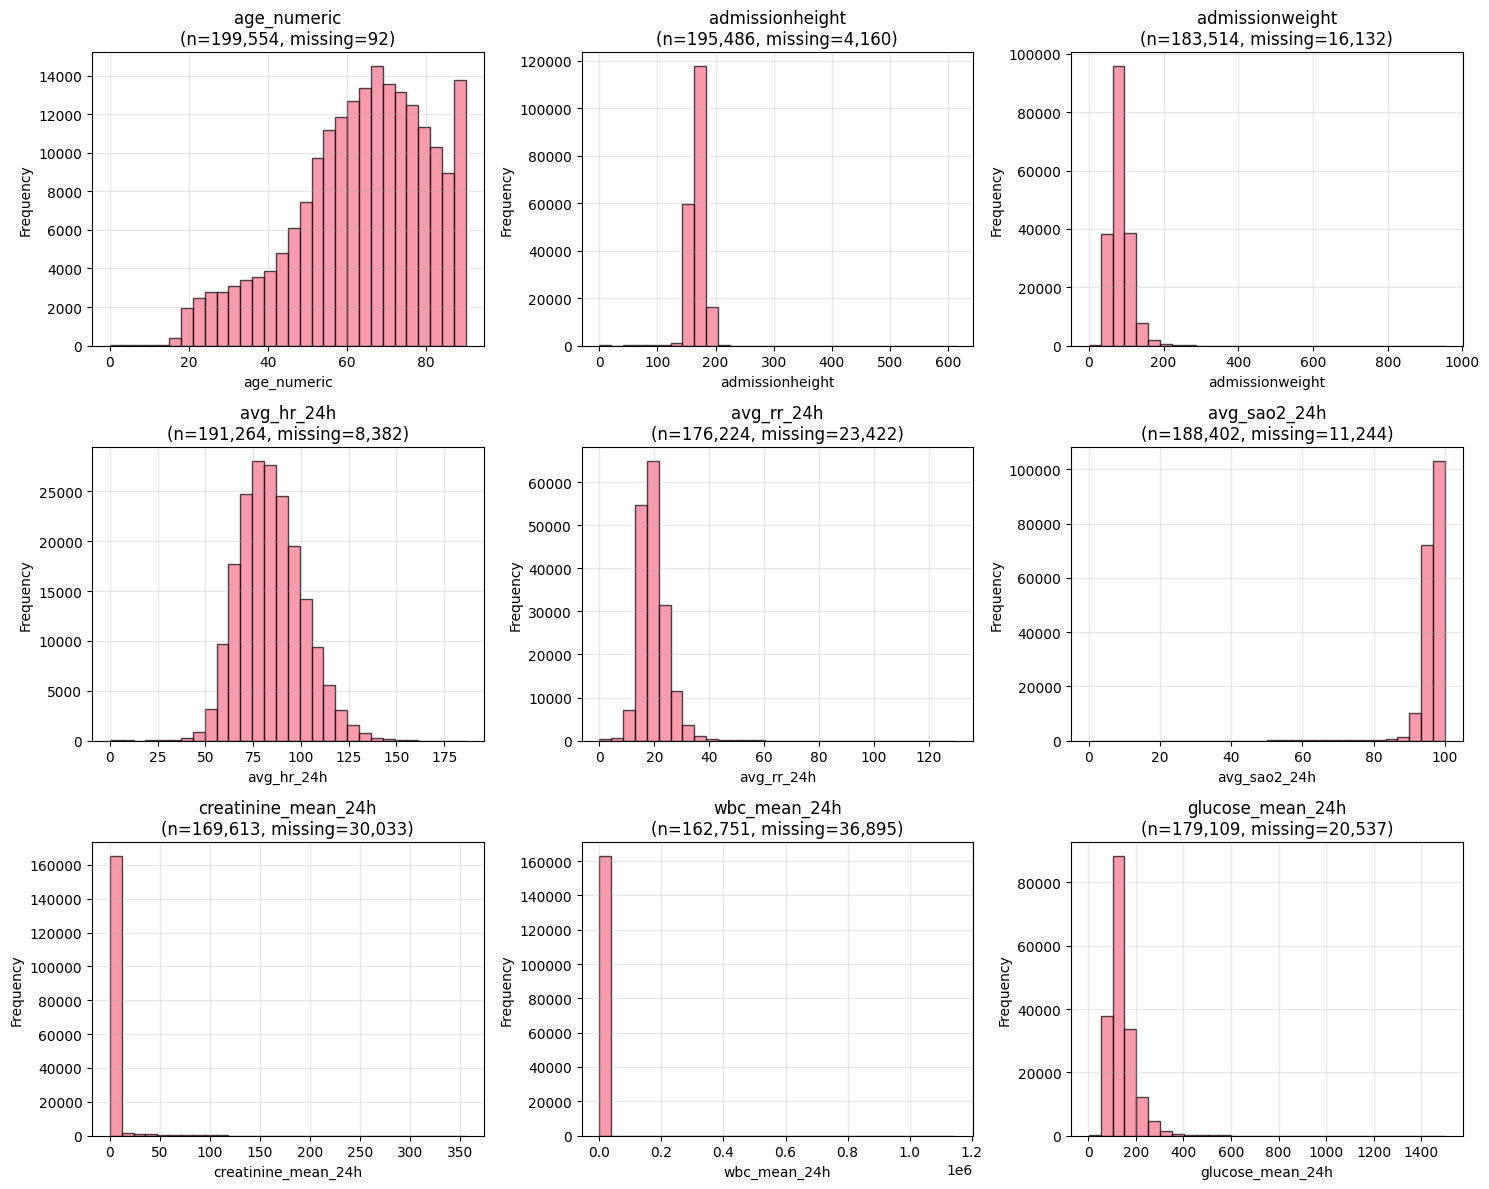

In [16]:
# Select key numeric features for visualization
key_features = [
    'age_numeric', 'admissionheight', 'admissionweight',
    'avg_hr_24h', 'avg_rr_24h', 'avg_sao2_24h',
    'creatinine_mean_24h', 'wbc_mean_24h', 'glucose_mean_24h'
]

# Filter to features that exist and have some non-null values
key_features = [f for f in key_features if f in df_features.columns and df_features[f].notna().sum() > 0]

# Create histograms
n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(key_features):
    data = df_features[feature].dropna()
    axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{feature}\n(n={len(data):,}, missing={df_features[feature].isnull().sum():,})')
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## Summary Statistics

In [17]:
# Summary statistics for numeric features
numeric_cols = [col for col in numeric_features if col != 'patientunitstayid']
summary_stats = df_features[numeric_cols].describe().T
summary_stats['missing_count'] = df_features[numeric_cols].isnull().sum()
summary_stats['missing_pct'] = (df_features[numeric_cols].isnull().sum() / len(df_features) * 100).round(2)

print("=== Summary Statistics for Numeric Features ===")
print(summary_stats.round(2))

=== Summary Statistics for Numeric Features ===
                             count        mean          std         min  \
los_days                  199646.0    2.695564     4.338915    0.000694   
prolonged_stay            199646.0    0.247638     0.431642         0.0   
age_numeric               199554.0   63.078615    17.182204         0.0   
admissionheight           195486.0  169.243915    13.704508         0.0   
admissionweight           183514.0   83.930669    27.085021         0.0   
unitvisitnumber           199646.0    1.276039     0.651345         1.0   
apache_intubated          170602.0    0.148802     0.355895         0.0   
apache_vent               170602.0    0.242295     0.428473         0.0   
apache_dialysis           170602.0    0.036952     0.188643         0.0   
apache_urine_24h          170602.0  895.984998  1639.094687 -11245.5648   
apache_wbc                170602.0    8.935544     9.097733        -1.0   
apache_temp               170602.0   33.836293      

## Export Data Sample for Review

In [18]:
# Create a sample for manual review
sample_size = min(1000, len(df_features))
df_sample = df_features.sample(n=sample_size, random_state=42)

print(f"\nCreated random sample of {sample_size} ICU stays for review")
print(f"Sample includes {df_sample['prolonged_stay'].sum()} prolonged stays and {(~df_sample['prolonged_stay'].astype(bool)).sum()} non-prolonged stays")


Created random sample of 1000 ICU stays for review
Sample includes 245 prolonged stays and 755 non-prolonged stays


## Next Steps for Imputation

Based on the missing value analysis, we should consider the following imputation strategies:

### High Priority (Features with >30% missing):
1. **APACHE features**: Consider using APACHE-specific imputation methods or domain knowledge
2. **Lab values**: May require clinical context for appropriate imputation
3. **Vital signs**: Time-series imputation methods may be appropriate

### Medium Priority (Features with 10-30% missing):
1. **Patient demographics**: Simple imputation (mode, median) may be sufficient
2. **Binary indicators**: Consider imputing as 0 (absence of event)

### Low Priority (Features with <10% missing):
1. May use simple imputation methods
2. Could consider multiple imputation for robustness

### Recommended Approaches:
- **Numeric features**: Median imputation or KNN imputation
- **Categorical features**: Mode imputation or "unknown" category
- **Binary indicators**: Zero imputation (assume event did not occur)
- **Consider**: Multiple imputation for sensitivity analysis
- **Feature engineering**: Create "missingness indicators" for features with substantial missing data

### Federated Learning Considerations:
- Imputation strategy must be consistent across all client sites
- Document imputation rules clearly for reproducibility
- Consider site-specific missingness patterns

In [19]:
# Close connection
conn.close()
print("\nDatabase connection closed.")


Database connection closed.
